In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

In [126]:
# Calculate MAPE values
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [127]:
# Load the data
data = pd.read_csv('C:\\Users\\tejas\\Desktop\\sample_1 daily.csv', parse_dates=['point_timestamp'], index_col='point_timestamp')

# Set the frequency to daily

data.index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')


data = data.drop('Unnamed: 0', axis = 1)


train_data = data.iloc[:int(len(data)*0.8)] #First 80 % is train data

In [128]:
# Arima 
def ARIM(data):
    # last 20% of the data as testing data
    test_data = data.iloc[int(len(data) * 0.8):]

    # Fit the model
    arima_model = sm.tsa.arima.ARIMA(train_data['point_value'], order=(1,1,1)) # using an autoregressive term of order 1, a differencing term of order 1, and a moving average term of order 1
    arima_model = arima_model.fit()

    # Generate predictions 

    arima_pred = arima_model.forecast(len(test_data))

    # Calculate mean absolute percentage error (MAPE)
    arima_mape = calculate_mape(test_data['point_value'], arima_pred)
    return arima_mape
#     print('MAPE:', arima_mape)

In [129]:
# SARIMA
def SARIMA(data):
    # last 20% of the data as testing data
    test_data = data.iloc[int(len(data) * 0.8):]

    # Fit the SARIMA model
    sarima_model = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 7)) # 7 indicates that there is a daily seasonality in the data
    sarima_model = sarima_model.fit()

    # Make predictions
    sarima_pred = sarima_model.forecast(len(test_data))

    # Calculate MAPE
    sarima_mape = calculate_mape(test_data['point_value'], sarima_pred)
    return sarima_mape
#     print('MAPE:', sarima_mape)

In [130]:
# XGBoost
def XGBoost(data):
    # last 20% of the data as testing data
    test_data = data[int(len(data) * 0.8):]

    # Define the features and target variable
    features = ['point_value']
    target = 'point_value'

    # Train the XGBoost model
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(train_data[features], train_data[target])

    # Make predictions on the test set
    xgb_preds = xgb_model.predict(test_data[features])

    # Calculate MAPE
    xgb_mape = calculate_mape(test_data[target], xgb_preds)
    return xgb_mape
#     print('MAPE:', xgb_mape)

In [149]:
# ETS
def ETS(data):
    # last 20% of the data as testing data
    test_data = data[int(len(data) * 0.8):]

    # Create and fit the ETS model
    ets_model = ETSModel(train_data['point_value'].astype(float), error='add', trend='add', seasonal='add', seasonal_periods=7)
    ets_model = ets_model.fit()


    # Make predictions on the test set
    ets_pred = ets_model.predict(start=test_data.index[0], end=test_data.index[-1])

    # Calculate MAPE
    ets_mape = calculate_mape(test_data['point_value'], ets_pred)
    return ets_mape
#     print('MAPE:', ets_mape)

In [150]:
# Selection Algorithm
# I am running all the above functions of the time series models and choosing least mape, the above functions are the 
# used in the selection algorithm
def selection(data):
    # Choose the model with the lowest MAPE
    arima_mape = ARIM(data)
    sarima_mape = SARIMA(data)
    xgb_mape = XGBoost(data)
    ets_mape = ETS(data)
    mape_values = {"ARIMA": arima_mape, "SARIMA": sarima_mape, "XGBoost": xgb_mape, "ETS": ets_mape}
    best_model = min(mape_values, key=mape_values.get)
    return best_model

# print("The best model is: ", best_model)


In [164]:
 # Predict for test data using Best model and plot

def prediction(best_model, data) :
    train_data = data.iloc[:int(len(data)*0.8)] #First 80 % is train data
    test_data = data[int(len(data) * 0.8):] # Last 20% is test

    # test_train_split can also be used

    if best_model == 'ARIMA':
        arima_model = sm.tsa.arima.ARIMA(train_data['point_value'], order=(1,1,1)) # using an autoregressive term of order 1, a differencing term of order 1, and a moving average term of order 1
        arima_model = arima_model.fit()

        # Generate predictions 

        pred = arima_model.forecast(len(test_data))

        # Calculate mean absolute percentage error (MAPE)
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
    elif best_model == 'SARIMA':
        # Fit the SARIMA model
        sarima_model = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 7)) # 7 indicates that there is a daily seasonality in the data
        sarima_model = sarima_model.fit()

        # Make predictions
        pred = sarima_model.forecast(len(test_data))

        # Calculate MAPE
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
    elif best_model == 'XGBoost':
        # Define the features and target variable
        features = ['point_value']
        target = 'point_value'

        # Train the XGBoost model
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(train_data[features], train_data[target])

        # Make predictions on the test set
        pred = xgb_model.predict(test_data[features])

        # Calculate MAPE
        mape = calculate_mape(test_data[target], pred)
#         print('MAPE:', mape)
    elif best_model == 'ETS':
        # Create and fit the ETS model
        ets_model = ETSModel(train_data['point_value'].astype(float), error='add', trend='add', seasonal='add', seasonal_periods=7)
        ets_model = ets_model.fit()


        # Make predictions on the test set
        pred = result.predict(start=test_data.index[0], end=test_data.index[-1])

        # Calculate MAPE
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
    df = data[int(len(data) * 0.75):]
    plt.plot(df.index, df.values, label='actual')
    plt.plot(test_data.index, pred, label='predicted')
    plt.legend()
    plt.show()
    return mape


In [165]:
# This is the connecter function which gives me all the desired outputs needed for FAST API
def connect(start_date, end_date):
    data1 = data.loc[start_date:end_date]
    best = selection(data1)
    ma = prediction(best, data1)
    print(best,ma)

In [167]:
bm = selection(data)
bm

'XGBoost'

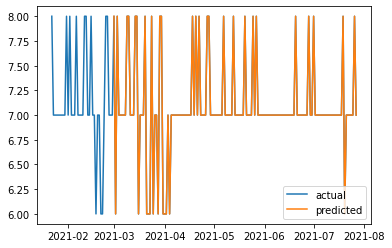

0.00035922799334430156

In [168]:
m = prediction(bm, data)
m

In [169]:
data.head(100)

,point_value
2019-07-14,6
2019-07-15,7
2019-07-16,6
2019-07-17,6
2019-07-18,7
...,...
2019-10-17,6
2019-10-18,7
2019-10-19,6
2019-10-20,6


In [155]:
data.tail()

,point_value
2021-07-23,7
2021-07-24,7
2021-07-25,7
2021-07-26,8
2021-07-27,7


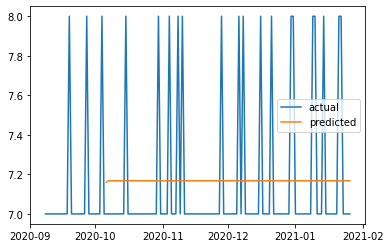

ARIMA 3.5992847781940918


In [174]:
connect('2019-07-14', '2021-01-26')